# Distributed Analysis

The Arnheim Framework bridges djangos ORM with cluster based analysis. A Representation inherits from the LarvikArray which in turn is a Proxy for xArray. All of the meta data is stored in this datafile so it is easily browsable.

In [2]:
import django
django.setup()

2020-02-14 14:26:22,294 [mandal.settings] INFO     Debugging build
2020-02-14 14:26:22,295 [mandal.settings] INFO     Hosting on ['*']


In [3]:
from dask.distributed import Client, progress
c = Client()

/opt/conda/lib/python3.7/site-packages/distributed/client.py:1074: VersionMismatchWarning: Mismatched versions found

msgpack
+------------------------+---------+
|                        | version |
+------------------------+---------+
| client                 | 0.6.1   |
| scheduler              | 0.6.2   |
| tcp://172.18.0.3:34691 | 0.6.2   |
+------------------------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


## Import

Representation is bergens binder of ImageStack where general x and y dimensions have not been altered to the original ImageStack, so 2D Rois are all perfectly aligned.

In [5]:
from bioconverter.models import Representation
from filters.logic.filters import  Prewitt, Mapping
from filters.logic.projections import MaxISP
import larvik.extenders

2020-02-14 14:26:30,841 [larvik.extenders] INFO     Making DataArrays Look Beautiful
2020-02-14 14:26:30,841 [larvik.extenders] INFO     Extending DataArray


In [10]:
reps = Representation.distributed.filter(type="initial", sample__creator__username__startswith="J")[:3]
reps


FieldError: Related Field got invalid lookup: createat

## Analysis

We have preselected every 5D unprocessed ("initial") Stack where the Sample originated from a Bioseries within a Bioimage in Locker starting with the Name "Caro". 

A Common Pitfall in Immunohistochemistry is overexposed Samples, where the data is clipped at the maximum value. In the following we are trying to analyse every Channel in these Stacks and calculate the amount of Pixels that are over a certain intensity threshold. We will distinguish between the multiple channels, and see if our aquisition has been uniform.

In [11]:
bag = reps.asBag()

In [12]:
def expandChannels(x):
    return [ x.sel(c=channel) for channel in x.c ]
        
def calculateOverPixelsForChannels(x):
    channelmeta = x.channels.data.compute()
    return {"name": str(x.name),"overpixels": int((x.data > 0.8).sum().compute()),"channel": str(channelmeta["Name"]),
"wavelength": float(channelmeta["EmissionWavelength"])}

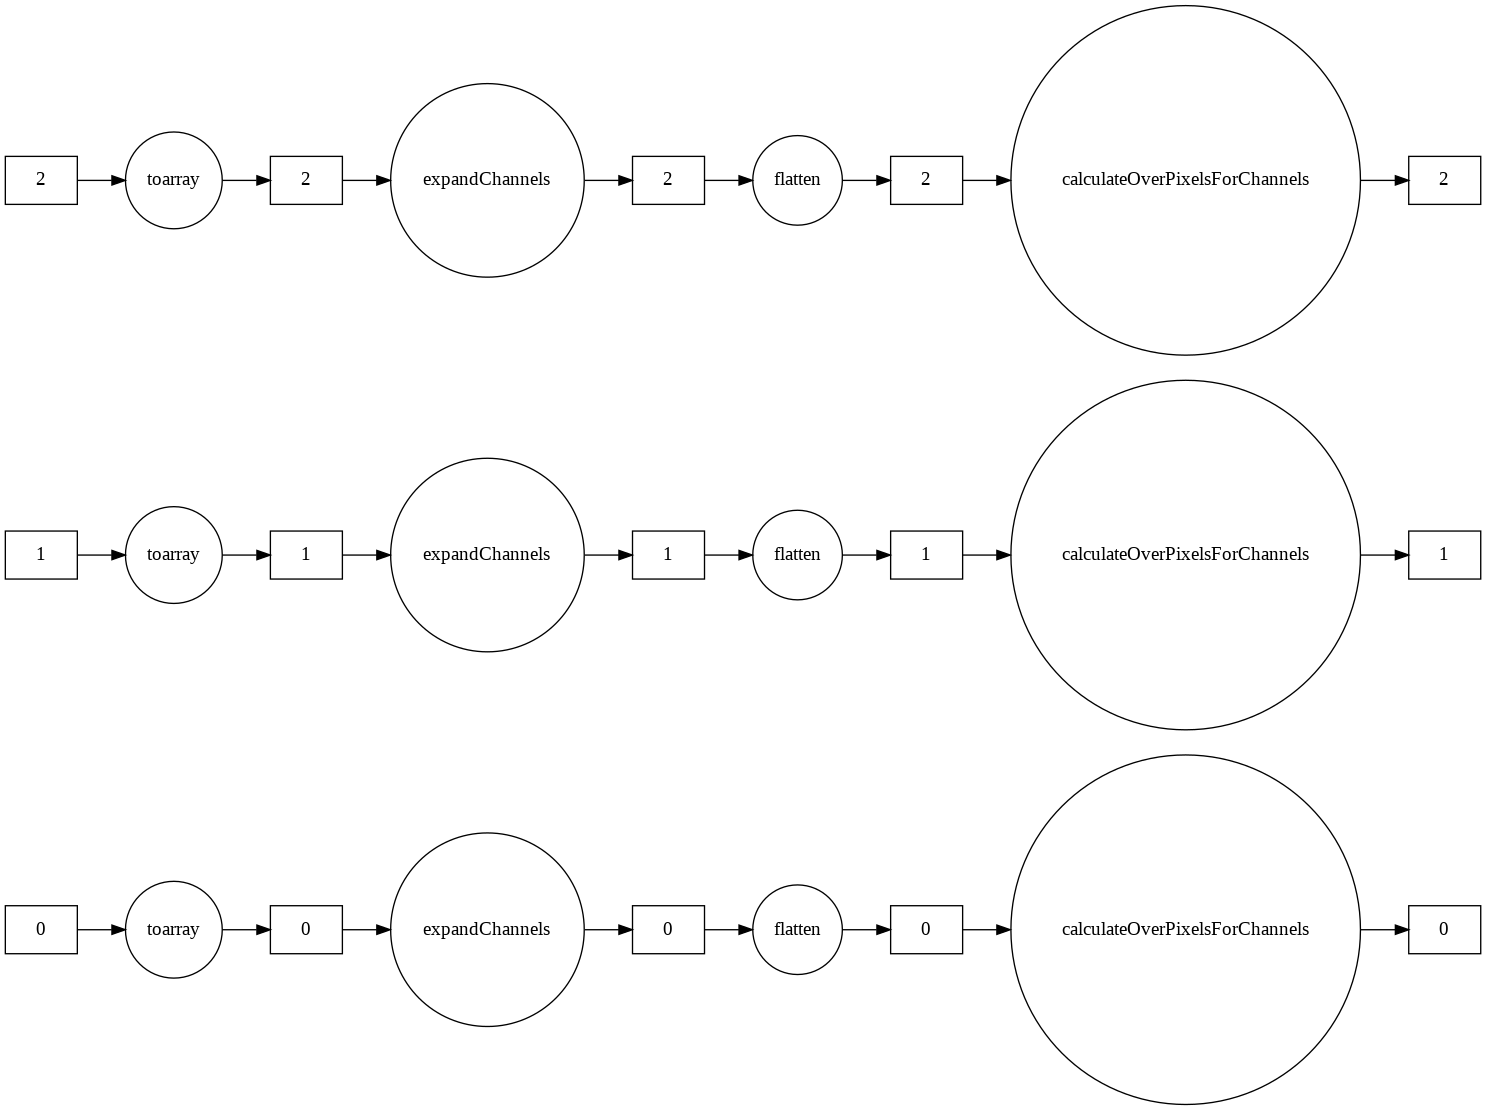

In [17]:
bag.map(expandChannels).flatten().map(calculateOverPixelsForChannels).visualize(rankdir="LR")

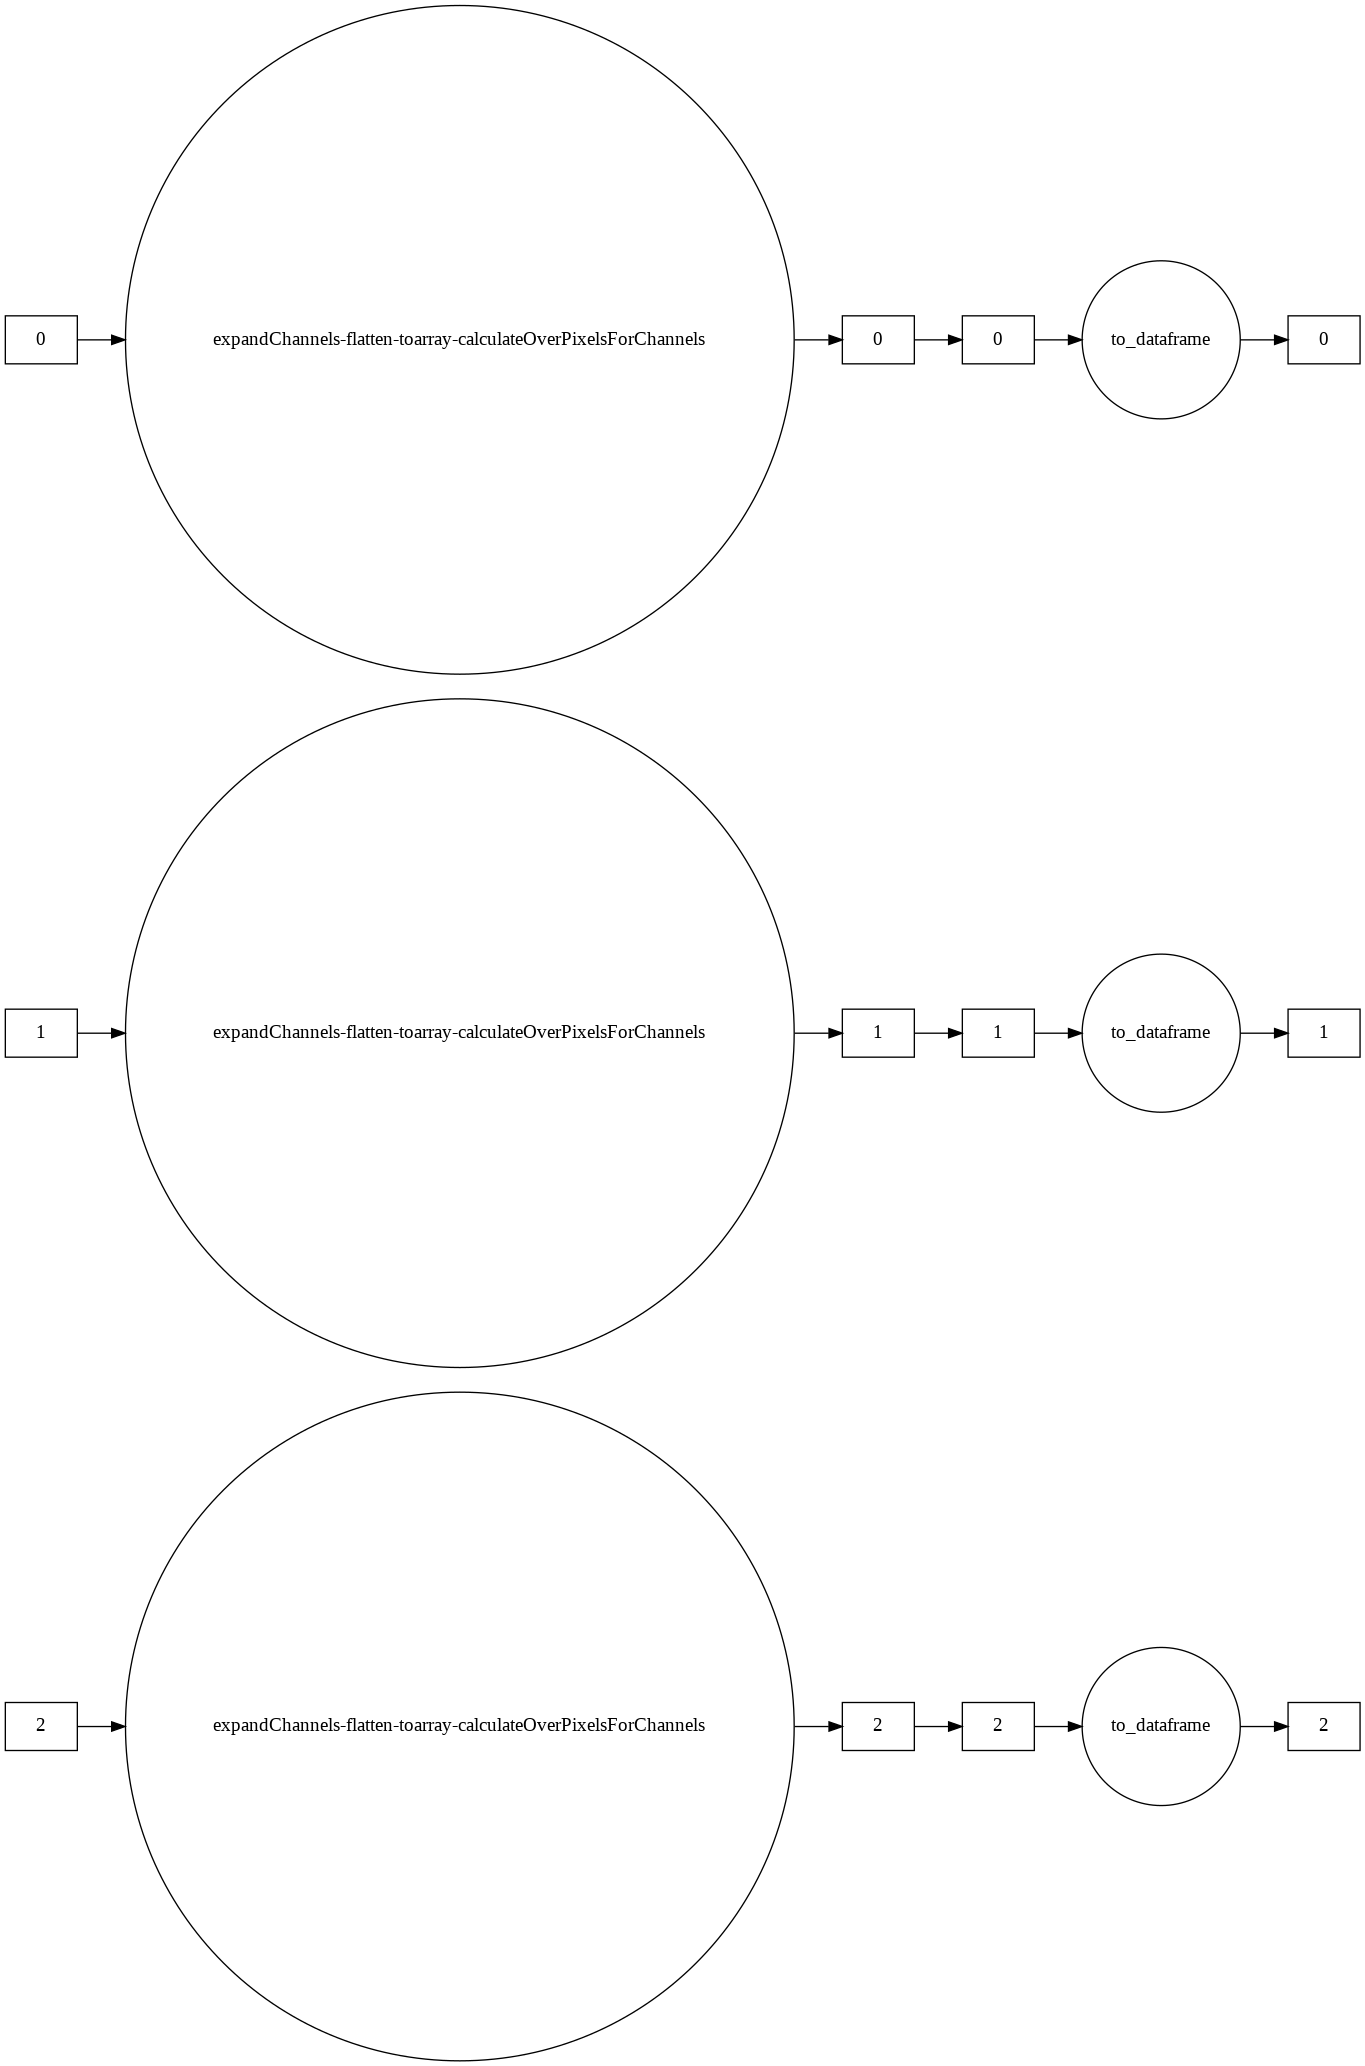

In [15]:
df.visualize(rankdir="LR")

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

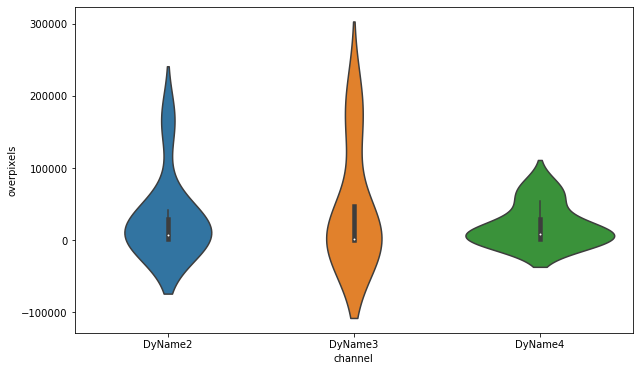

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(x="channel",y="overpixels", data=df, ax=ax)

## Evaluation
As long as no computation is called the array has not yet been altered. We can call this for each array individual or for the whole stack

In [13]:
df.head()

,name,overpixels,channel,wavelength
0,Initial Stack,1603,DyName2,535.5
1,Initial Stack,226,DyName3,600.0
2,Initial Stack,73977,DyName4,683.0
0,Initial Stack,665,DyName2,535.5
1,Initial Stack,662,DyName3,600.0


## Profile Statistical Analysis 

Pandas profile is an easy and performant solution to do massive analyzation task with multi-variant statistical analysis, just let it run through our data

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, title='Pandas Profiling Report', html={'style':{'full_width':True}})
profile.to_notebook_iframe()